In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud 
from nltk.corpus import stopwords 
import nltk

In [2]:
input_filename = "datos_finales_para_ml.csv"
try:
    df_ml = pd.read_csv(input_filename)
    print("Datos cargados")
except Exception as e:
    print("Error al cargar")

Datos cargados


        length_chars  length_tokens
count   11173.000000   11173.000000
mean      586.077866     122.925356
std      3493.097886     771.216927
min        15.000000       3.000000
25%       206.000000      44.000000
50%       357.000000      75.000000
75%       591.000000     122.000000
max    191799.000000   42647.000000


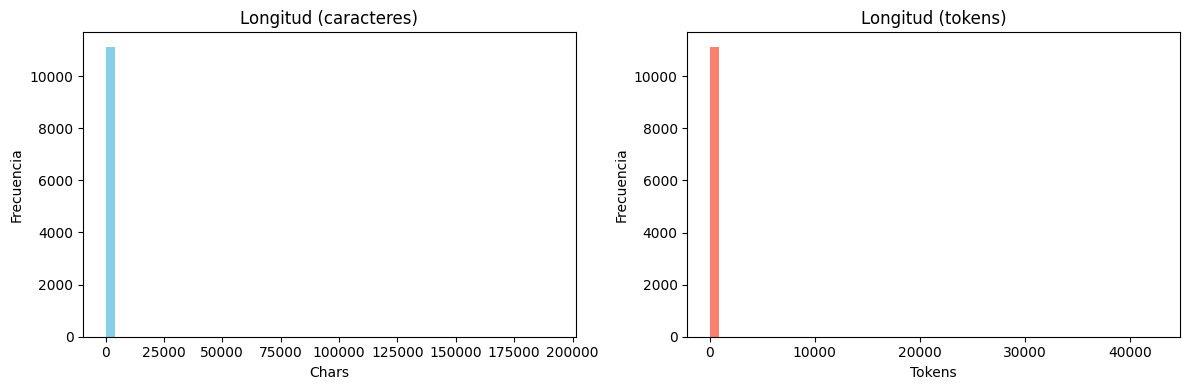

In [3]:
# Cálculo de longitudes en caracteres y tokens
df_ml['length_chars'] = df_ml['full_chat'].str.len()
df_ml['length_tokens'] = df_ml['full_chat'].apply(lambda x: len(str(x).split()))

# Mostrar estadísticos
print(df_ml[['length_chars','length_tokens']].describe())

# Histograma de longitudes
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(df_ml['length_chars'], bins=50, color='skyblue')
axes[0].set(title='Longitud (caracteres)', xlabel='Chars', ylabel='Frecuencia')
axes[1].hist(df_ml['length_tokens'], bins=50, color='salmon')
axes[1].set(title='Longitud (tokens)', xlabel='Tokens', ylabel='Frecuencia')
plt.tight_layout()
plt.show()

In [9]:
# --- Undersampling de la Clase Mayoritaria ---
df_grooming = df_ml[df_ml['label'] == 1]
df_normal = df_ml[df_ml['label'] == 0]

# Define el número de muestras normales. Ejemplo: 5 veces el número de muestras de grooming.
# Ajusta 'n_multiplier' según sea necesario. Si quieres 1:1, n_multiplier = 1.
n_multiplier = 5
num_normal_samples = min(len(df_normal), len(df_grooming) * n_multiplier)

df_normal_undersampled = df_normal.sample(n=num_normal_samples, random_state=42)

df_ml_balanced = pd.concat([df_grooming, df_normal_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)


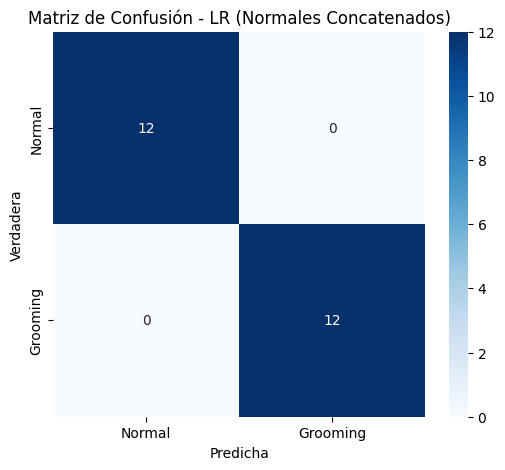


Reporte de Clasificación - LR (Normales Concatenados):
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00        12
Grooming (1)       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



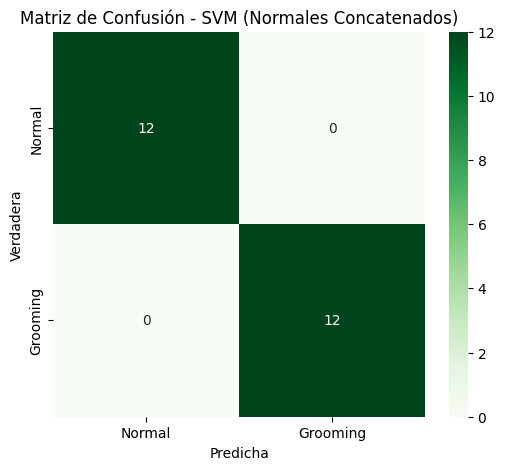


Reporte de Clasificación - SVM (Normales Concatenados):
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00        12
Grooming (1)       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [14]:
num_grooming_samples = len(df_grooming)
num_normal_samples_target = num_grooming_samples # Para un ratio 1:1

concatenated_normal_chats = []
current_concatenated_chat = ""
current_length = 0
target_avg_length_grooming = df_grooming['full_chat'].str.len().mean()

# Barajar los chats normales para que la concatenación no siga siempre el mismo orden
df_normal_shuffled = df_normal.sample(frac=1, random_state=42).reset_index(drop=True)

for index, row in df_normal_shuffled.iterrows():
    chat_text = row['full_chat']
    chat_length = len(chat_text)

    if not current_concatenated_chat:
        current_concatenated_chat = chat_text
        current_length = chat_length
    else:
        current_concatenated_chat += " " + chat_text
        current_length += (1 + chat_length)

    if current_length >= target_avg_length_grooming or index == len(df_normal_shuffled) - 1 :
        if len(concatenated_normal_chats) < num_normal_samples_target:
            concatenated_normal_chats.append(current_concatenated_chat)
            current_concatenated_chat = ""
            current_length = 0
        else:
            break # Ya hemos generado suficientes chats normales concatenados

if current_concatenated_chat and len(concatenated_normal_chats) < num_normal_samples_target:
    concatenated_normal_chats.append(current_concatenated_chat)


df_normal_concatenated = pd.DataFrame({'full_chat': concatenated_normal_chats, 'label': 0})

# Asegurarse de no tener más chats normales concatenados que chats de grooming
if len(df_normal_concatenated) > num_grooming_samples:
    df_normal_concatenated = df_normal_concatenated.sample(n=num_grooming_samples, random_state=42).reset_index(drop=True)


df_ml_concatenated_balanced = pd.concat([df_grooming, df_normal_concatenated]).sample(frac=1, random_state=42).reset_index(drop=True)


X_concat = df_ml_concatenated_balanced['full_chat']
y_concat = df_ml_concatenated_balanced['label']

vectorizer_concat = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=3, # Ajustado ligeramente ya que el dataset es más pequeño
    max_df=0.8 # Ajustado ligeramente
)
X_tfidf_concat = vectorizer_concat.fit_transform(X_concat)

X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(X_tfidf_concat, y_concat, test_size=0.25, random_state=42, stratify=y_concat)


# Modelo 1: Regresión Logística con datos concatenados
lr_model_concat = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model_concat.fit(X_train_concat, y_train_concat)
y_pred_lr_concat = lr_model_concat.predict(X_test_concat)

cm_lr_concat = confusion_matrix(y_test_concat, y_pred_lr_concat)
fig_lr_concat, ax_lr_concat = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_lr_concat, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Grooming'], yticklabels=['Normal', 'Grooming'], ax=ax_lr_concat)
ax_lr_concat.set_title("Matriz de Confusión - LR (Normales Concatenados)")
ax_lr_concat.set_xlabel("Predicha")
ax_lr_concat.set_ylabel("Verdadera")
plt.show()
print("\nReporte de Clasificación - LR (Normales Concatenados):")
print(classification_report(y_test_concat, y_pred_lr_concat, target_names=['Normal (0)', 'Grooming (1)']))


# Modelo 2: SVM con datos concatenados
svm_model_concat = SVC(kernel='linear', C=1.0, probability=True, random_state=42, class_weight='balanced')
svm_model_concat.fit(X_train_concat, y_train_concat)
y_pred_svm_concat = svm_model_concat.predict(X_test_concat)

cm_svm_concat = confusion_matrix(y_test_concat, y_pred_svm_concat)
fig_svm_concat, ax_svm_concat = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_svm_concat, annot=True, fmt="d", cmap="Greens", xticklabels=['Normal', 'Grooming'], yticklabels=['Normal', 'Grooming'], ax=ax_svm_concat)
ax_svm_concat.set_title("Matriz de Confusión - SVM (Normales Concatenados)")
ax_svm_concat.set_xlabel("Predicha")
ax_svm_concat.set_ylabel("Verdadera")
plt.show()
print("\nReporte de Clasificación - SVM (Normales Concatenados):")
print(classification_report(y_test_concat, y_pred_svm_concat, target_names=['Normal (0)', 'Grooming (1)']))

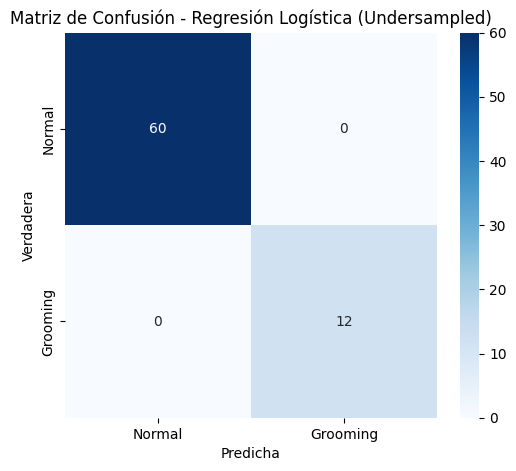


Reporte de Clasificación (Regresión Logística - Undersampled):
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00        60
Grooming (1)       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



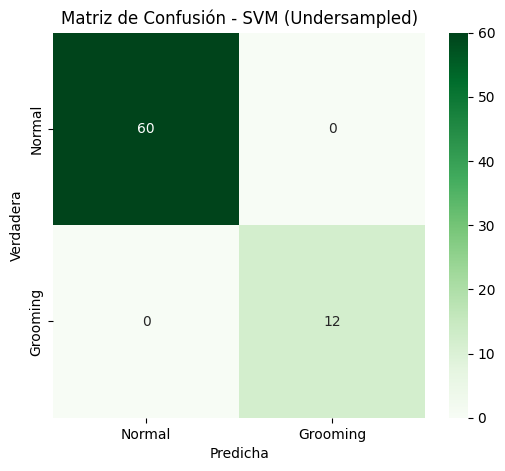


Reporte de Clasificación (SVM - Undersampled):
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00        60
Grooming (1)       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [12]:
X = df_ml_balanced['full_chat']
y = df_ml_balanced['label']

vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=5,
    max_df=0.7
)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42, stratify=y)


# --- Modelado y Evaluación ---

# Modelo 1: Regresión Logística
# class_weight='balanced' puede ser menos necesario o incluso contraproducente después del undersampling manual,
# pero puedes probar con y sin él.
#lr_model = LogisticRegression(max_iter=1000, random_state=42) # Prueba sin class_weight primero
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
fig_lr, ax_lr = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Grooming'], yticklabels=['Normal', 'Grooming'], ax=ax_lr)
ax_lr.set_title("Matriz de Confusión - Regresión Logística (Undersampled)")
ax_lr.set_xlabel("Predicha")
ax_lr.set_ylabel("Verdadera")
plt.show()
print("\nReporte de Clasificación (Regresión Logística - Undersampled):")
print(classification_report(y_test, y_pred_lr, target_names=['Normal (0)', 'Grooming (1)']))

# Modelo 2: Support Vector Machine (SVM)
#svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42) # Prueba sin class_weight primero
svm_model = SVC(kernel='linear', C=1.0, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)
fig_svm, ax_svm = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", xticklabels=['Normal', 'Grooming'], yticklabels=['Normal', 'Grooming'], ax=ax_svm)
ax_svm.set_title("Matriz de Confusión - SVM (Undersampled)")
ax_svm.set_xlabel("Predicha")
ax_svm.set_ylabel("Verdadera")
plt.show()
print("\nReporte de Clasificación (SVM - Undersampled):")
print(classification_report(y_test, y_pred_svm, target_names=['Normal (0)', 'Grooming (1)']))

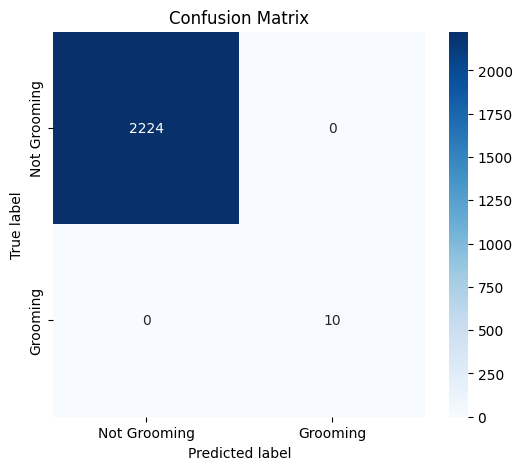


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2224
           1       1.00      1.00      1.00        10

    accuracy                           1.00      2234
   macro avg       1.00      1.00      1.00      2234
weighted avg       1.00      1.00      1.00      2234



In [6]:

X = datos_combinados['full_chat']
y = datos_combinados['label']

vectorizer = TfidfVectorizer(max_features=10000, stop_words = 'english', sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y , test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression (max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(figsize=(6, 5))
# Dibujamos el heatmap de la matriz de confusión
sns.heatmap(
    cm,                    # Matriz de confusión
    annot=True,                # Muestra los números dentro de cada celda
    fmt="d",                   # Formato entero
    cmap="Blues",              # Colormap azul
    xticklabels=['Not Grooming', 'Grooming'],
    yticklabels=['Not Grooming', 'Grooming'],
    ax=axes
)

axes.set_title("Confusion Matrix")
axes.set_xlabel("Predicted label")
axes.set_ylabel("True label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))